In [1]:
import PIL
from PIL import Image
import numpy as np
from IPython.display import display, clear_output
from sklearn.cluster import KMeans
from numba import njit,prange
from numpy import uint8

In [2]:
shp = (256,256,3)
arr = np.zeros(shp, dtype=uint8)
c1 = (32,32,16)
c2 = (130,40,37)
c3 = (27,180,48)

for i in range(shp[0]):
    for j in range(shp[1]):
        if (i-c1[0])**2 + (j-c1[1])**2 <= c1[2]**2:
            arr[i][j] = np.array([255,0,0], dtype=uint8)
        elif (i-c2[0])**2 + (j-c2[1])**2 <= c2[2]**2:
            arr[i][j] = np.array([0,255,0], dtype=uint8)
        elif (i-c3[0])**2 + (j-c3[1])**2 <= c3[2]**2:
            arr[i][j] = np.array([0,0,255], dtype=uint8)
        else:
            arr[i][j] = np.array([255,255,255], dtype=uint8)

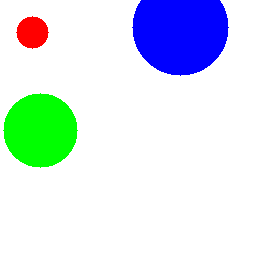

In [3]:
im = Image.fromarray(arr)
display(im)

In [4]:
@njit
def norm(vec):
    return (vec[0]**2 + vec[1]**2 + vec[2]**2)**0.5

@njit(parallel=True)
def get_diffs(diffs, car):
    cs = car.shape
    for i in prange(cs[0]):
        for j in range(cs[1]):
            l = max(i-1,0)
            r = min(i+1,cs[0]-1)
            u = max(j-1,0)
            d = min(j+1,cs[1]-1)
            cur = car[i][j]
            d1 = car[l][j]
            d2 = car[r][j]
            d3 = car[i][u]
            d4 = car[i][d]
            d5 = car[l][u]
            d6 = car[r][u]
            d7 = car[l][d]
            d8 = car[r][d]
            a1 = norm(cur-d1)
            a2 = norm(cur-d2)
            a3 = norm(cur-d3)
            a4 = norm(cur-d4)
            a5 = norm(cur-d5)
            a6 = norm(cur-d6)
            a7 = norm(cur-d7)
            a8 = norm(cur-d8)
            avg = (a1+a2+a3+a4+a5+a6+a7+a8)/8 #max is 442
            v1 = 1-(avg * 0.0022641187)#puts it in range [0,1]
            v2 = (((80/127)*((v1-0.5)**(1/3)))+0.5)
#             if v1 < 0.1:
#                 v1 = 0
#             if v1 > 0.9:
#                 v1 = 1
            val = (255 * v1)
            #val = 255 if v1 >= 0.1 else 0
            
            diffs[i][j] = np.array([val,val,val], dtype=uint8)

In [5]:
@njit(parallel=True)
def get_diffs2(diffs, car):
    cs = car.shape
    for i in prange(cs[0]):
        for j in range(cs[1]):
            col = car[i][j]
            val = (col[0] + (col[1]<<3) + (col[2]<<6))//73 #smoother
#             val = ((col[0]>>5) | ((col[1]>>5)<<3) | ((col[2]>>5)<<6))>>1 #just worse
            diffs[i][j] = np.array([val,val,val], dtype=uint8);
        

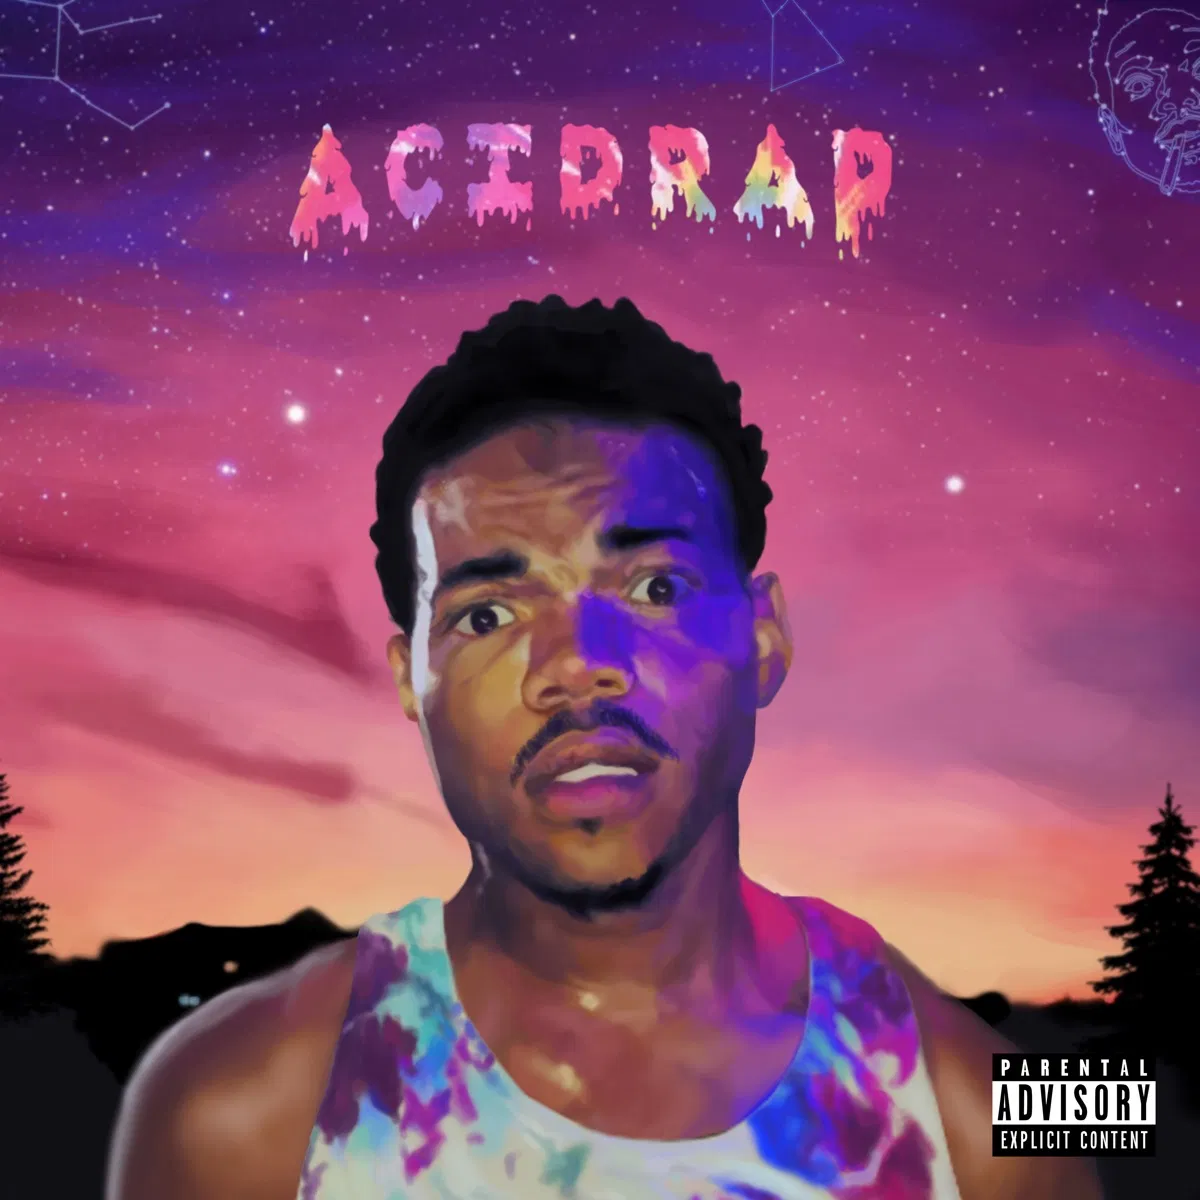

In [7]:
imgs = ['AJR.jpg', 'cyanide.jpg', 'acid-rap.jpg', 'grad.png', 'all.jpg', 'freud.jpg', 'kanye_1.jpg', 'quinn.jpg']
cyanide = Image.open(imgs[2])
display(cyanide)
car = np.asarray(cyanide).astype(np.int16)
cs = car.shape

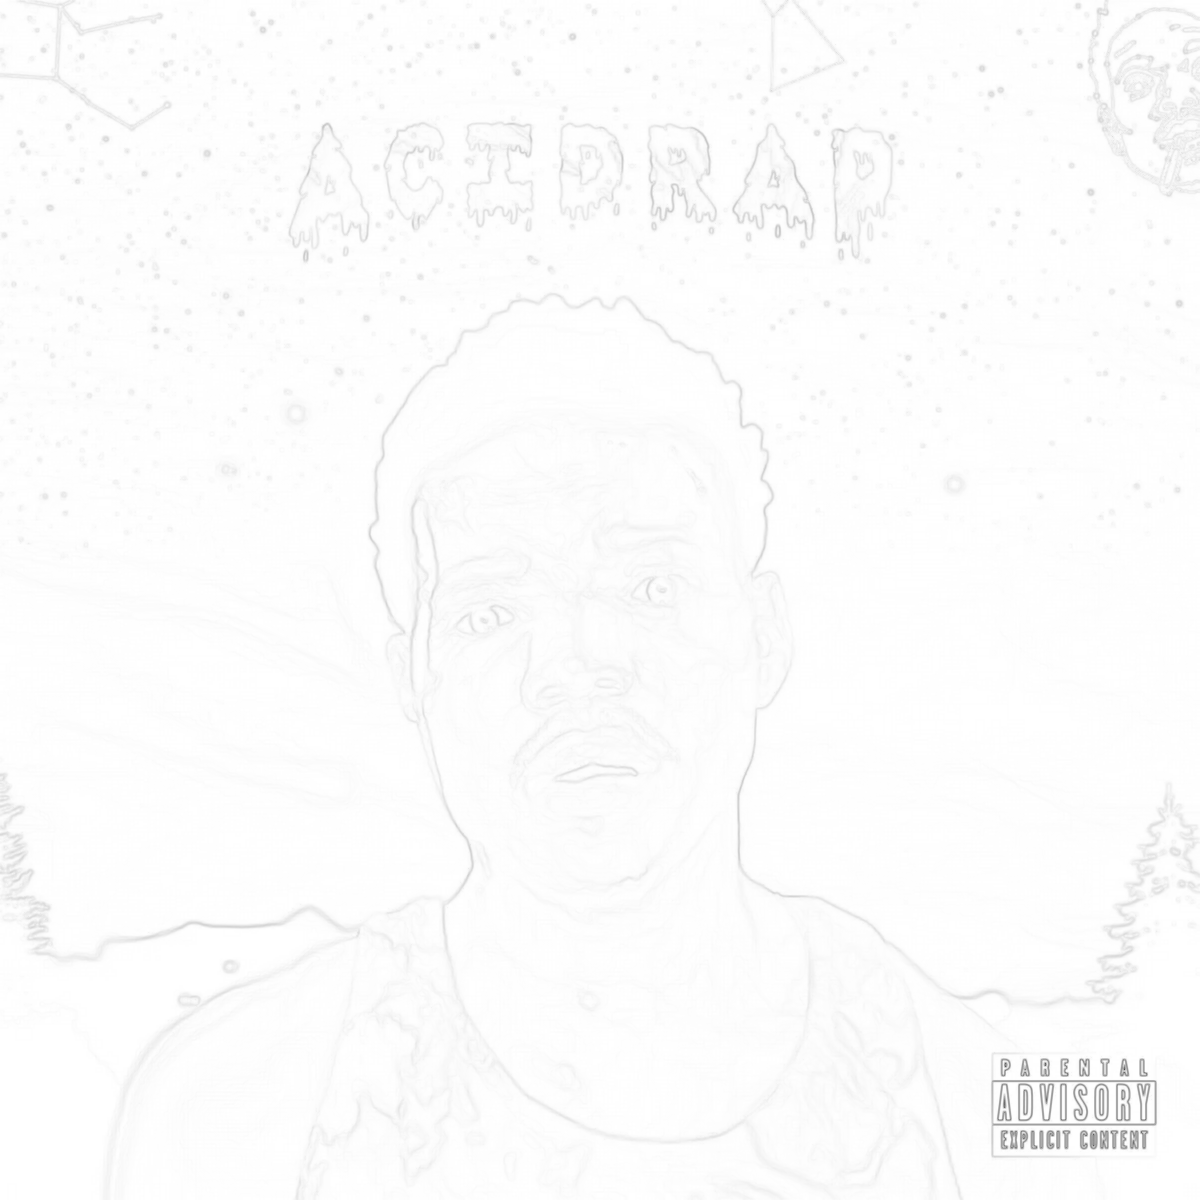

In [8]:
diffs = np.zeros(cs, dtype=uint8)
get_diffs(diffs, car)
cnn = Image.fromarray(diffs)
display(cnn)

In [ ]:
@njit(parallel=True)
def fillrgb(rgb):
    for i in prange(4096):
        for j in range(4096):
            idx = i*4096 + j
#             rgb[i][j][0] = j//16
#             rgb[i][j][1] = i%256
#             rgb[i][j][2] = (j%16) + (i//256)*16
            rgb[i][j][0] = idx%256
            rgb[i][j][1] = (idx>>8)%256
            rgb[i][j][2] = (idx>>16)%256
            
rgb = np.zeros((4096,4096,3), dtype=uint8)
fillrgb(rgb)
display(Image.fromarray(rgb))
Image.fromarray(rgb).save("all.jpg")

In [402]:

        
        

def idk(diffs):
    cs = car.shape
    for i in range(cs[0]):
        for j in range(cs[1]):
            if i<j or (j<cs[1]/2 and i > cs[0]/2 and i<(j+cs[1]/2)) or (j<cs[1]*0.25 and i > cs[0]*0.75 and i<(j+cs[1]*0.75)) or (j<cs[1]*0.125 and i > cs[0]*0.875 and i<(j+cs[1]*0.875)) or (j<cs[1]*(1/16) and i > cs[0]*(15/16) and i<(j+cs[1]*(15/16))):
                diffs[i][j] = car[i][j]
            else:
                col = car[i][j]
                val = (col[0] + (col[1]<<3) + (col[2]<<6))//73 #smoother
    #             val = ((col[0]>>5) | ((col[1]>>5)<<3) | ((col[2]>>5)<<6))>>1 #just worse
                diffs[i][j] = np.array([val,val,val], dtype=uint8);
                
            if (i<cs[1]/2 and j > cs[0]/2 and j<(i+cs[1]/2)) or (i<cs[1]*0.25 and j > cs[0]*0.75 and j<(i+cs[1]*0.75)) or (i<cs[1]*0.125 and j > cs[0]*0.875 and j<(i+cs[1]*0.875)) or (i<cs[1]*(1/16) and j > cs[0]*(15/16) and j<(i+cs[1]*(15/16))):
                col = car[i][j]
                val = (col[0] + (col[1]<<3) + (col[2]<<6))//73 #smoother
    #             val = ((col[0]>>5) | ((col[1]>>5)<<3) | ((col[2]>>5)<<6))>>1 #just worse
                diffs[i][j] = np.array([val,val,val], dtype=uint8);

#                  :

In [403]:
diffs = np.zeros(car.shape, dtype=uint8)
idk(diffs)
cnn = Image.fromarray(diffs.astype(uint8))

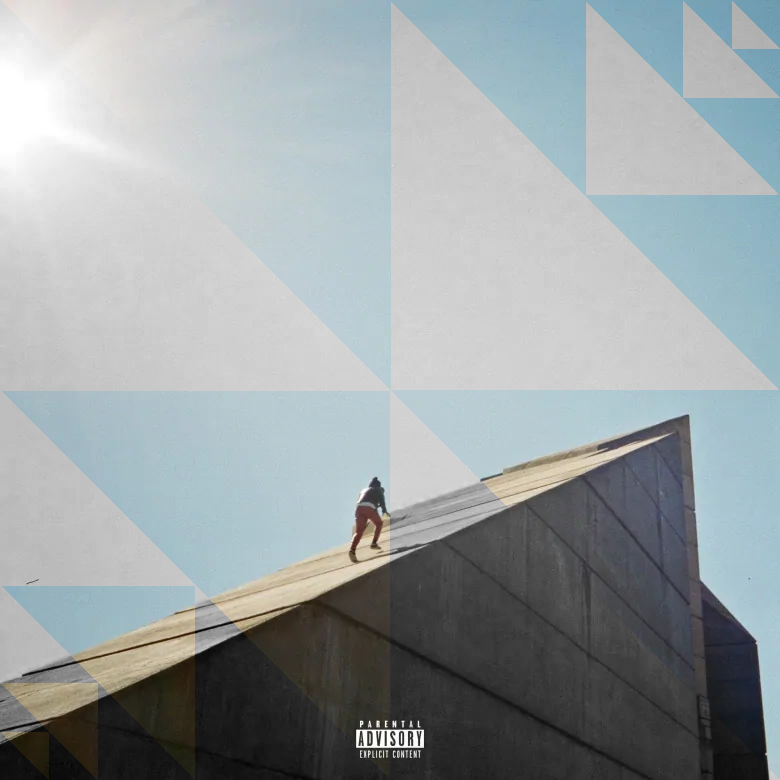

In [404]:
cnn

In [391]:
cnn.save("serp.jpg")